Here are some $\LaTeX$ macros (you can't see them, but when you evaluate this cell they are loaded into memory and you can use them later).
$$
\newcommand{\dd}{\mathrm{d}}
\newcommand{\diff}[2]{\frac{ \dd #1 } {\frac \dd #2}}
\newcommand{\chieff}{\chi_\mathrm{eff}}
\newcommand{\piso}{p_\mathrm{iso}}
\newcommand{\pali}{p_\mathrm{ali}}
$$

In [1]:
using PyCall
using PyPlot
using StatsFuns

@pyimport seaborn as sns
sns.set_style("ticks")
sns.set_palette("colorblind")
sns.set_context("notebook")

Cole had a great idea, the thrust of which is the following: assume that you have some distribution for the spin magnitudes of black holes (and it is common to the more- and less-massive BH in any binary).  The distribution of $\chieff$ that is implied by this magnitude distribution differs depending on whether you assume that the angular distribution is isotropic or aligned.  In general, isotropic angular distributions concentrate more of the $\chieff$ distribution near zero, since that is where most of the angular phase space is.  Here we derive the distributions for $\chieff$ under various reasonable, yet straw-man assumptions.

First, $\chieff$ is defined by 
$$
\chieff = \frac{c}{GM} \left( \frac{s_1^z}{m_1} + \frac{s_2^z}{m_2} \right) = \frac{1}{M} \left( m_1 a_1^z + m_2 a_2^z \right)
$$
where the $\hat{z}$ axis is aligned with the orbital angular momentum, $s_{1,2}$ are the spin angular momentum of the components of the binary, and $a_{1,2}$ are the spin parameters of the black holes in the binary.  

First we derive the distribution for $a^z$ when we know the distribution for $a$ and the angular distribution is (a) isotropic and (b) aligned.  First isotropic: Then $a^z$ is equal to the product of $a$ with a uniform random variable on $[-1,1]$ ($\iota = \cos \theta$, with $\theta$ the colatitude on a sphere).  Therefore 
$$
p\left( a^z \right) = \int_{-1}^{1} \dd \iota \, \int_0^1 \dd a \, \delta\left( a^z - a \iota \right) \frac{p(a)}{2} = \int_{-1}^{1} \dd \iota \, \int_0^1 \dd a \, \frac{\delta\left( a - \frac{a^z}{\iota} \right)}{\left| \iota \right|} \frac{p(a)}{2}.
$$
Now, noting that the distribution of $a^z$ is an even function, assume that $a^z > 0$; since $0 \leq a \leq 1$, we must have $\iota \geq a^z$ if the $\delta$-function is to be "activated," so
$$
p\left( a^z \right) = \int_{a^z}^1 \dd \iota \, \frac{p\left( \frac{a^z}{\iota} \right)}{2 \iota}.
$$
The even assumption implies 
$$
p\left( a^z \right) = \int_{\left| a^z \right|}^1 \dd \iota \, \frac{p\left( \frac{\left|a^z\right|}{\iota} \right)}{2 \iota}
$$
When the angles are aligned, we have
$$
p\left( a^z \right) = \begin{cases}
p_a\left(a^z \right) & a^z > 0\\
0 & \mathrm{otherwise}
\end{cases}.
$$
In other words, the distribution of $a^z$ follows $a$ when $a^z$ is positive, and is zero otherwise.

For example, when the magnitude distribution is flat, $p(a) = 1$, the isotropic angle assumption implies that 
$$
\piso\left( a^z \right) = -\frac{\log \left| a^z \right|}{2},
$$
while the aligned assumption implies that
$$
\pali\left( a^z \right) = \begin{cases}
1 & a^z > 0 \\
0 & a^z < 0
\end{cases}
$$

Here is some code that implements distributions for $p(a) = 1$, $p(a) = 2 a$, and $p(a) = 2(1-a)$; these are flat, increasing, and decreasing, respectively.

In [2]:
function p_iso_flat_wrong(chieff)
    -0.5*log(abs(chieff))
end
function p_ali_flat_wrong(chieff)
    if chieff > 0
        1.0
    else
        0.0
    end
end

function p_iso_inc_wrong(chieff)
    1.0 - abs(chieff)
end
function p_ali_inc_wrong(chieff)
    if chieff > 0
        2.0*chieff
    else
        0.0
    end
end

function p_iso_dec_wrong(chieff)
    abs(chieff)-log(abs(chieff))-1.0
end
function p_ali_dec_wrong(chieff)
    if chieff > 0
        2.0*(1.0-chieff)
    else
        0.0
    end
end

p_ali_dec_wrong (generic function with 1 method)

If the mass ratio, $q$, (recall: $0 \leq q \leq 1$) is zero, this is all we need; if not, then 
$$
\chieff = \frac{1}{1+q}\left(a_1^z + q a_2^z\right),
$$
and the distribution is given by a convolution of the distributions for $a^z$:
$$
p\left(\chieff \right) = \int_{-1}^1 \dd a_1^z \, \int_{-1}^1 \dd a_2^z \, \delta\left( \chieff - \frac{1}{(1+q)} \left[a_1^z + q a_2^z \right]\right) p\left( a_1^z\right) p\left(a_2^z\right),
$$
which becomes, after some manipulation,
$$
p\left(\chieff \right) = \int_{-1}^1 \dd a_1^z \, \int_{-1}^1 \dd a_2^z \, \delta\left( a_1^z + q a_2^z - (1+q)\chieff \right) (1+q) p\left( a_1^z\right) p\left(a_2^z\right),
$$
and more manipulation:
$$
p\left(\chieff \right) = \int_{\max\left(-1, \frac{(1+q)\chieff - 1}{q} \right)}^{\min\left(1, \frac{(1+q)\chieff+1}{q}\right)} \dd a_2^z \, (1+q) p\left(a_2^z\right) p\left((1+q)\chieff - q a_2^z \right).
$$

Ugh.  This is not going to be analytic, even if we specialise to $q = 1$ (equal mass); though a good check of the math is that it works out to the above single-spin distribution when $q=0$.

I guess the best thing from here is to simulate the distribution empirically.  The code below does that, currently specialised to $q = 1$ (but the code to draw is generic, so can be used to produce other $q$ values).

A plot of the distributions of spin:

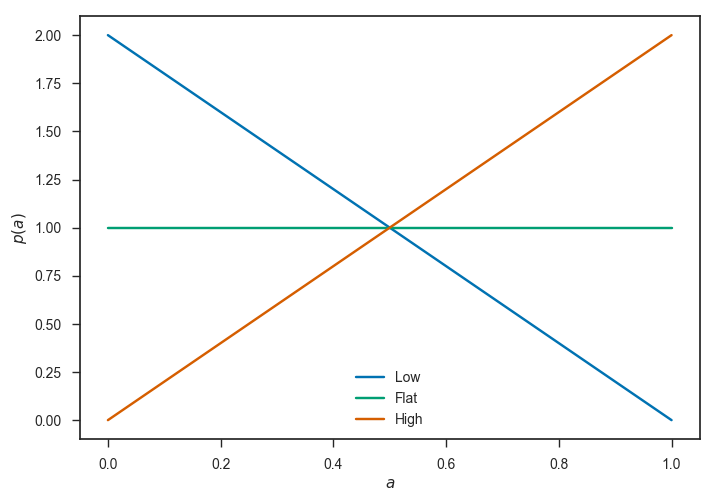

In [5]:
as = collect(linspace(0, 1, 1000))
as_low = 2.0*(1.0-as)
as_flat = ones(size(as))
as_high = 2.0*as
plot(as, as_low, label="Low")
plot(as, as_flat, label="Flat")
plot(as, as_high, label="High")
legend(loc="best")
xlabel(L"$a$")
ylabel(L"$p(a)$")
savefig("../plots/pa.pdf")

open("../data/a-distr.csv", "w") do f
    write(f, "a,pa_low,pa_flat,pa_high\n")
    writecsv(f, hcat(as, as_low, as_flat, as_high))
end

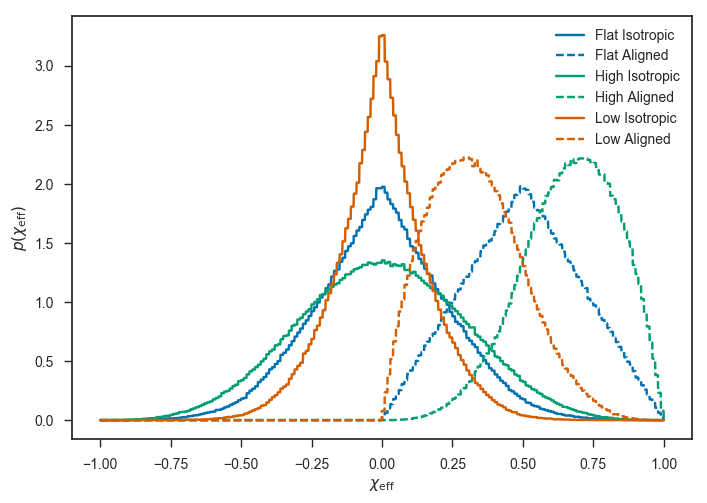

In [7]:
function make_histogram_density(bins, counts)
    N = sum(counts)
    probs = counts ./ (N*diff(bins))
    
    nbin = size(bins, 1) - 1
    
    function p(x)
        rng = searchsorted(bins, x)
        bin = last(rng)
        if (bin < 1) || (bin > nbin)
            0.0
        else
            probs[bin]
        end
    end
end

function hist_counts(bins, xs)
    nbin = size(bins, 1)-1
    counts = zeros(nbin)
    for x in xs
        rng = searchsorted(bins, x)
        bin = last(rng)
        if (bin < 1) || (bin > nbin)
            # Do nothing
        else
            counts[bin] = counts[bin] + 1
        end
    end
    (bins, counts)
end

function draw_iota()
    2.0*rand() - 1.0
end
function draw_increasing()
    sqrt(rand())
end
function draw_decreasing()
    1.0 - sqrt(1.0 - rand())
end

function draw_chieff(q, draw_chi)
    1.0/(1.0+q)*(draw_chi() + q*draw_chi())
end

bins = collect(-1:0.01:1) # Hopefully spaced finely enough

p_ali_flat = make_histogram_density(bins, hist_counts(bins, [draw_chieff(1.0, rand) for i in 1:1000000])[2])
p_iso_flat = make_histogram_density(bins, hist_counts(bins, [draw_chieff(1.0, () -> draw_iota()*rand()) for i in 1:1000000])[2])

p_ali_inc = make_histogram_density(bins, hist_counts(bins, [draw_chieff(1.0, draw_increasing) for i in 1:1000000])[2])
p_iso_inc = make_histogram_density(bins, hist_counts(bins, [draw_chieff(1.0, () -> draw_iota()*draw_increasing()) for i in 1:1000000])[2])

p_ali_dec = make_histogram_density(bins, hist_counts(bins, [draw_chieff(1.0, draw_decreasing) for i in 1:1000000])[2])
p_iso_dec = make_histogram_density(bins, hist_counts(bins, [draw_chieff(1.0, () -> draw_iota()*draw_decreasing()) for i in 1:1000000])[2])

chieffs = collect(-1:0.001:1)

pif = p_iso_flat.(chieffs)
paf = p_ali_flat.(chieffs)

pii = p_iso_inc.(chieffs)
pai = p_ali_inc.(chieffs)

pid = p_iso_dec.(chieffs)
pad = p_ali_dec.(chieffs)

plot(chieffs, pif, "-", color=sns.color_palette()[1], label="Flat Isotropic")
plot(chieffs, paf, "--", color=sns.color_palette()[1], label="Flat Aligned")

plot(chieffs, pii, "-", color=sns.color_palette()[2], label="High Isotropic")
plot(chieffs, pai, "--", color=sns.color_palette()[2], label="High Aligned")

plot(chieffs, pid, "-", color=sns.color_palette()[3], label="Low Isotropic")
plot(chieffs, pad, "--", color=sns.color_palette()[3], label="Low Aligned")

legend(loc="best")
xlabel(L"$\chi_\mathrm{eff}$")
ylabel(L"$p\left( \chi_\mathrm{eff}\right)$")
savefig("../plots/chi-eff-distributions.pdf")

open("../data/chieff-dist.csv", "w") do f
    write(f, "chieff,p_iso_flat,p_ali_flat,p_iso_high,p_ali_high,p_iso_low,p_ali_low\n")
    writecsv(f, hcat(chieffs, pif, paf, pii, pai, pid, pad))
end

## Hierarchical Analysis

LIGO measures $\chieff$ better than any other spin parameter, but still with significant uncertainty, so we need to properly incorporate measurement uncertainty in our analysis; thus our analysis must be *hierarchical*.  In a hierarchical analysis, we assume that each event has a true, but unknown, value of the effective spin, drawn from the population distribution, which may have some parameters $\lambda$; then the system is observed, represented by the likelihood function, which results in a distribution for the true effective spin (and all other paremeters describing the system) consistent with the data.  Combining, the *joint* posterior on each system's $\chieff^i$ parameters and the population parameters $\lambda$ implied by a set of observations each with data $d^i$, is 
$$
p\left( \left\{ \chieff^i \right\}, \lambda \mid \left\{ d^i \right\} \right) \propto \left[ \prod_{i=1}^{N_\mathrm{obs}} p\left(d^i \mid \chieff^i \right) p\left( \chieff^i \mid \lambda \right) \right] p\left(\lambda\right).
$$

The components of this formula are

 * The GW (marginal) likelihood, $p\left(d \mid \chieff\right)$.  "Marginal" because we are (implicitly) *integrating* over all parameters of the signal but $\chieff$.  Note that it is the *likelihood*, not the *posterior* that matters for the hierarchical analysis; if we are given posterior distributions or posterior samples, we need to re-weight to "remove" the prior and obtain the likelihood.
 * The population distribution for $\chieff$, $p\left( \chieff \mid \lambda \right)$.  This function can be parameterised by population-level parameters, $\lambda$.  (In the cases discussed above, there are no parameters for the population.)
 * The prior on the population-level parameters, $p(\lambda)$.
 
If we don't care about the individual event $\chieff$ paremetrs, we can integrate them out, obtaining 
$$
p\left( \lambda \mid \left\{ d^i \right\} \right) \propto \left[ \prod_{i=1}^{N_\mathrm{obs}} \int \dd \chieff^i \, p\left(d^i \mid \chieff^i \right) p\left( \chieff^i \mid \lambda \right) \right] p\left(\lambda\right).
$$
If we are given posterior samples of $\chieff^{ij}$ ($i$ labels the event, $j$ labels the particular posterior sample) drawn from an analysis using a prior $p\left( \chieff \right)$, then we can approximate the integral by an re-weighted average of the population distribution over the samples (here $p\left( \chieff^{ij} \right)$ is the prior used to produce the posterior samples):
$$
p\left( \lambda \mid \left\{ d^i \right\} \right) \propto \left[ \prod_{i=1}^{N_\mathrm{obs}} \frac{1}{N_i} \sum_{j=1}^{N_i} \frac{p\left( \chieff^{ij} \mid \lambda \right)}{p\left( \chieff^{ij} \right)} \right] p\left(\lambda\right).
$$

In a fully-spinning `LALInference` analysis, our prior for $\chieff$ is given by the combination of a flat prior in the spin magnitudes with an isotropic prior in angles.

The code below computes the marginal likelihood for a population model with distribution `p_chieff` using a list of posterior samples where the prior used is `p_prior`:

In [8]:
function marginal_model_likelihood(chieff_samples, p_chieff, p_prior)
    ll = 0.0
    for ce in chieff_samples
        margl = mean(p_chieff.(ce) ./ p_prior.(ce))
        if margl == 0.0
            margl = 1.0/size(chieff_samples, 1) # Regularise if we don't have any samples
        end
        ll += log(margl) 
    end
    ll
end

marginal_model_likelihood (generic function with 1 method)

## Mock Analysis of the 2.9 LIGO Events

We will mock up some distributions for the LIGO events.  We will use the median and 90% intervals from the [O1 BBH Paper](https://arxiv.org/abs/1606.04856).

In [9]:
function ninetyrange_to_musigma(med, upper_interval, lower_interval)
    sigma = (upper_interval + lower_interval)/3.29  # The 90% interval of a Gaussian ~ 3.29*sigma
    (med, sigma)
end

ninetyrange_to_musigma (generic function with 1 method)

In [10]:
muGW150914, sigmaGW150914 = ninetyrange_to_musigma(-0.06, 0.14, 0.14)
muLVT151012, sigmaLVT151012 = ninetyrange_to_musigma(0.0, 0.3, 0.2)
muGW151226, sigmaGW151226 = ninetyrange_to_musigma(0.21, 0.2, 0.1)
muGW170104, sigmaGW170104 = ninetyrange_to_musigma(-0.12, 0.21, 0.30)

(-0.12,0.15501519756838905)

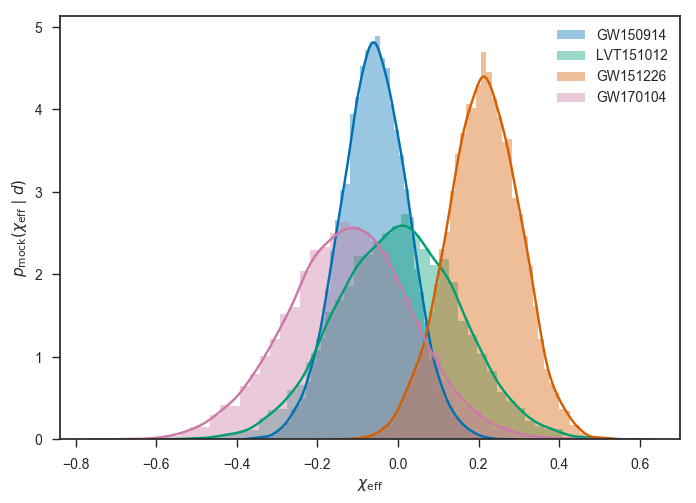

In [11]:
mocksamples = [mu + sigma*randn(10000) for (mu, sigma) in zip([muGW150914, muLVT151012, muGW151226, muGW170104], [sigmaGW150914, sigmaLVT151012, sigmaGW151226, sigmaGW170104])]
evtnames = ["GW150914", "LVT151012", "GW151226", "GW170104"]
for (s,n) in zip(mocksamples, evtnames)
    sns.distplot(s, label=n)
end
legend(loc="best")
xlabel(L"$\chi_\mathrm{eff}$")
ylabel(L"$p_\mathrm{mock}\left( \chi_\mathrm{eff} \mid d \right)$")
savefig("../plots/chi-eff-mock-posteriors.pdf")

open("../data/chieff-event-samples.csv", "w") do f
    write(f, "GW150914,LVT151012,GW151226,GW170104\n")
    writecsv(f, hcat(mocksamples...))
end

A very rough, approximate, method for estimating the odds ratio is 
$$
\frac{p\left( d \mid I \right)}{p\left( d \mid A \right)} \simeq
    \frac{P\left( -0.25 \leq \chieff \leq 0.25 \right)}{P\left( 0 \leq \chieff \leq 0.5 \right)}
$$

This is implemented below:

In [12]:
ers = [sum((-0.25 .< chieff) & (chieff .< 0.25))/sum((0 .< chieff) & (chieff .< 0.5)) for chieff in mocksamples]
reduce((*), ers)

18.29256368085315

If we get more events, then we can estimate the average accumulated log-odds:

In [13]:
function gaussian_cdf(mu, sigma, x)
     0.5*erfc((mu-x)/(sqrt(2.0)*sigma))
end
function inv_gaussian_cdf(x)
    sqrt(2)*erfcinv(2.0*x)
end
function expected_odds(chieff_limit, sigma)
    odds = [(gaussian_cdf(mu, sigma, chieff_limit) - gaussian_cdf(mu, sigma, -chieff_limit))/(gaussian_cdf(mu, sigma, 2*chieff_limit) - gaussian_cdf(mu, sigma, 0)) for mu in 2.0*chieff_limit*rand(1000) - chieff_limit]
    exp(mean(log(odds)))
end

expected_odds (generic function with 1 method)

In [14]:
expected_odds(0.25, 0.1)

3.1501858317797624

If we get ten more events, on top of our factor of five odds ratio, we are now at 

In [15]:
er_10 = 5*3.0^10
println(@sprintf("After ten more events, odds ratio becomes %.2g or %.2g sigma", er_10, inv_gaussian_cdf(0.5/er_10)))

After ten more events, odds ratio becomes 3e+05 or 4.6 sigma


Now suppose that the spin magnitudes get cut in half, but the uncertainty in the measurement stays the same:
$$
\frac{p\left( d \mid I \right)}{p\left( d \mid A \right)} \simeq
    \frac{P\left( -0.125 \leq \chieff \leq 0.125 \right)}{P\left( 0 \leq \chieff \leq 0.25 \right)}
$$

In [16]:
ers = [sum((-0.125 .< chieff) & (chieff .< 0.125))/sum((0 .< chieff) & (chieff .< 0.25)) for chieff in mocksamples]
reduce((*), ers)

2.4245170315719378

You can see that the evidence ratio becomes pretty close to one.  And each new event will contribute:

In [17]:
expected_odds(0.125, 0.1)

1.6304728324963653

So, after 10 events we have an odds ratio of 20:

In [18]:
er_10_small = 1.08*1.64^10
println(@sprintf("After ten more events, odds ratio becomes %.2g or %.2g sigma", er_10_small, inv_gaussian_cdf(0.5/er_10_small)))

After ten more events, odds ratio becomes 1.5e+02 or 2.7 sigma


The key to this plot: 

 * First letter `{"F", "H", "L"}` => flat magnitude distribution, increasing magnitude distribution, decreasing magnitude distribution.
 * Second letter `{"I", "A"}` => isotropic angle distribution, aligned (positive) angle distribution

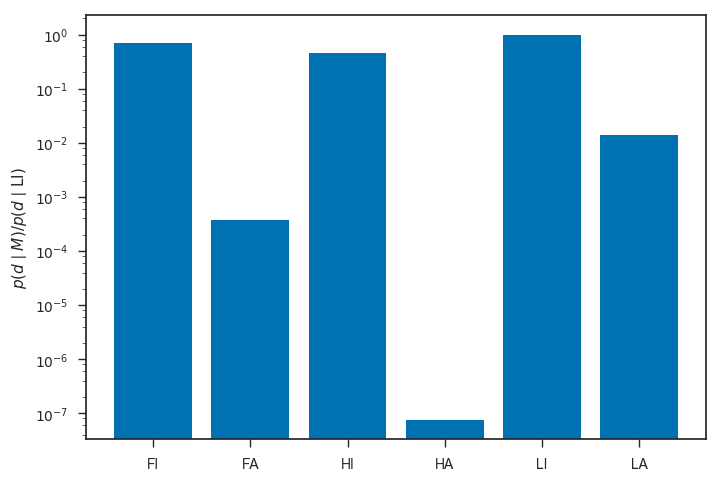

In [21]:
ll_iso_flat = marginal_model_likelihood(mocksamples, p_iso_flat, p_iso_flat)
ll_ali_flat = marginal_model_likelihood(mocksamples, p_ali_flat, p_iso_flat)
ll_iso_inc = marginal_model_likelihood(mocksamples, p_iso_inc, p_iso_flat)
ll_ali_inc = marginal_model_likelihood(mocksamples, p_ali_inc, p_iso_flat)
ll_iso_dec = marginal_model_likelihood(mocksamples, p_iso_dec, p_iso_flat)
ll_ali_dec = marginal_model_likelihood(mocksamples, p_ali_dec, p_iso_flat)

lls = [ll_iso_flat, ll_ali_flat, ll_iso_inc, ll_ali_inc, ll_iso_dec, ll_ali_dec]
lls -= ll_iso_dec # Re-normalise to decreasing-isotropic

xs = collect(1:6)

bar(xs, exp(lls), align="center")
yscale("log")

gca()[:set_xticklabels](["", "FI", "FA", "HI", "HA", "LI", "LA", ""])
ylabel(L"$p\left( d \mid M \right) / p\left( d \mid \mathrm{LI} \right)$")
savefig("../plots/O1-model-selection.pdf")

open("../data/four-event-model-selection-no-mixture.csv", "w") do f
    write(f, "FI,FA,HI,HA,LI,LA\n")
    writecsv(f, [exp(lls)])
end

In [20]:
function trapz(ys, xs)
    sum(0.5*diff(xs).*(ys[2:end] + ys[1:end-1]))
end

trapz (generic function with 1 method)

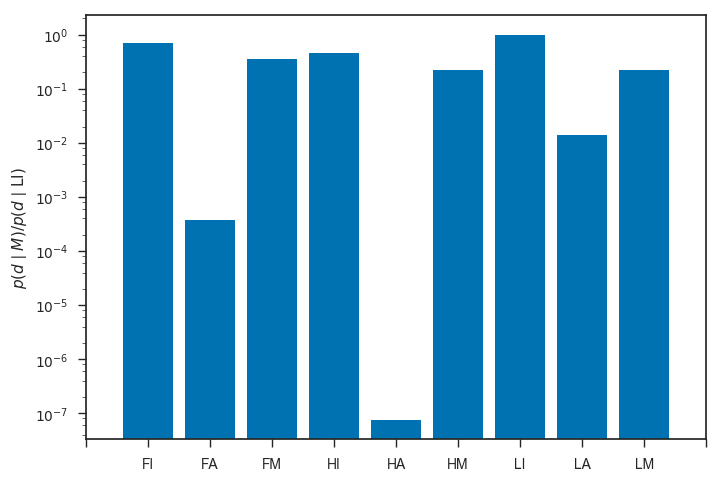

In [22]:
ll_iso_flat = marginal_model_likelihood(mocksamples, p_iso_flat, p_iso_flat)
ll_ali_flat = marginal_model_likelihood(mocksamples, p_ali_flat, p_iso_flat)
ll_iso_inc = marginal_model_likelihood(mocksamples, p_iso_inc, p_iso_flat)
ll_ali_inc = marginal_model_likelihood(mocksamples, p_ali_inc, p_iso_flat)
ll_iso_dec = marginal_model_likelihood(mocksamples, p_iso_dec, p_iso_flat)
ll_ali_dec = marginal_model_likelihood(mocksamples, p_ali_dec, p_iso_flat)

fs = collect(0:0.01:1)
ll_mix_flat_fs = [logsumexp(log(f)+ll_iso_flat, log1p(-f) + ll_ali_flat) for f in fs]
ll_mix_inc_fs = [logsumexp(log(f)+ll_iso_inc, log1p(-f) + ll_ali_inc) for f in fs]
ll_mix_dec_fs = [logsumexp(log(f)+ll_iso_dec, log1p(-f) + ll_ali_dec) for f in fs]

ll_mix_flat = log(trapz(exp(ll_mix_flat_fs), fs))
ll_mix_inc = log(trapz(exp(ll_mix_inc_fs), fs))
ll_mix_dec = log(trapz(exp(ll_mix_dec_fs), fs))

lls = [ll_iso_flat, ll_ali_flat, ll_mix_flat, ll_iso_inc, ll_ali_inc, ll_mix_inc, ll_iso_dec, ll_ali_dec, ll_mix_inc]
lls -= ll_iso_dec # Re-normalise to decreasing-isotropic

xs = collect(1:9)

bar(xs, exp(lls), align="center")
yscale("log")

gca()[:set_xticks](collect(0:10))
gca()[:set_xticklabels](["", "FI", "FA", "FM", "HI", "HA", "HM", "LI", "LA", "LM", ""])
ylabel(L"$p\left( d \mid M \right) / p\left( d \mid \mathrm{LI} \right)$")
savefig("../plots/Wills_evidence_ratio_figure_with_mixture_models.pdf")

open("../data/four-event-model-selection.csv", "w") do f
    write(f, "FI,FA,FM,HI,HA,HM,LI,LA,LM\n")
    writecsv(f, [exp(lls)])
end

We want to turn the evidence ratio between the best isotropic and best aligned models into a "sigma".  This uses a two-sided definition of p-value (either model *could* have been preferred).

In [23]:
er_iso_ali = exp(max(ll_iso_flat, ll_iso_inc, ll_iso_dec)-max(ll_ali_flat, ll_ali_dec, ll_ali_inc))
println(@sprintf("Odds ratio between best isotropic and best aligned is %.2g", 1.0/er_iso_ali))
println(@sprintf("Corresponds to %.2g sigma", inv_gaussian_cdf(0.5/er_iso_ali)))

Odds ratio between best isotropic and best aligned is 0.014
Corresponds to 2.5 sigma


## Mock O2 Catalog

We generate a mock-O2 catalog by choosing a random uncertainty from one of the three events, picking a $\chieff^\mathrm{true}$ from the flat-isotropic distribution, generating an "observation" of this via $\chieff^\mathrm{obs} = \chieff^\mathrm{true} + N(0,\sigma)$, whence the posterior is $\chieff \sim N\left( \chieff^\mathrm{obs}, \sigma \right) \piso\left( \chieff \right)$. 

Below is the money plot for the paper.  We generate 1000 mock-O2's (10 additional events), plus the existing O1's, for each of the six distributions for $\chieff$, and perform the model selection for each O1+O2.  Plotted are the resulting median (blue bar) and 68% interval (green line) odds ratios for each model; the "true" model in each set of O1+O2's is outlined in red and normalises the remaining odds ratios (i.e. is fixed to 1).  The "isotropic" scenarios occupy the top row, and the "aligned" scenarios occupy the bottom row.  

A few things to note:

* Because we are appending the existing O1 samples to the mock-O2 catalogs, there is no requirement that the "true" model have the highest odds ratio.  In particular, the existing samples, all at low $\chieff$ strongly disfavour the increasing-aligned scenario, so even when that is truth, other aligned scenarios come out ahead after only 10 more events.
* A model from the same "aligned"/"isotropic" class as the true model is always preferred by at least 3-sigma ($10^{-4}$ odds ratio).
* We have difficulty distinguishing among the $p(a)$ distributions post-O2, even though we can determine the angular distribution with confidence.  This should justify our *very simple* models for the magnitude distribution, though we can always check what happens with more extreme versions.

This cell takes a *long* time to run, so don't evaluate it unless you are prepared to wait.

In case FI, median iso-aligned odds ratio 1.6e-09 (      6 sigma)
            5% iso-aligned odds ratio     0.00032 (    3.6 sigma)


In case FA, median iso-aligned odds ratio 0.00049 (    3.5 sigma)
            5% iso-aligned odds ratio       0.012 (    2.5 sigma)
In case HI, median iso-aligned odds ratio 4.5e-09 (    5.9 sigma)
            5% iso-aligned odds ratio     0.00034 (    3.6 sigma)
In case HA, median iso-aligned odds ratio 1.5e-07 (    5.3 sigma)
            5% iso-aligned odds ratio     2.6e-05 (    4.2 sigma)
In case LI, median iso-aligned odds ratio 5.4e-10 (    6.2 sigma)
            5% iso-aligned odds ratio     2e-05 (    4.3 sigma)


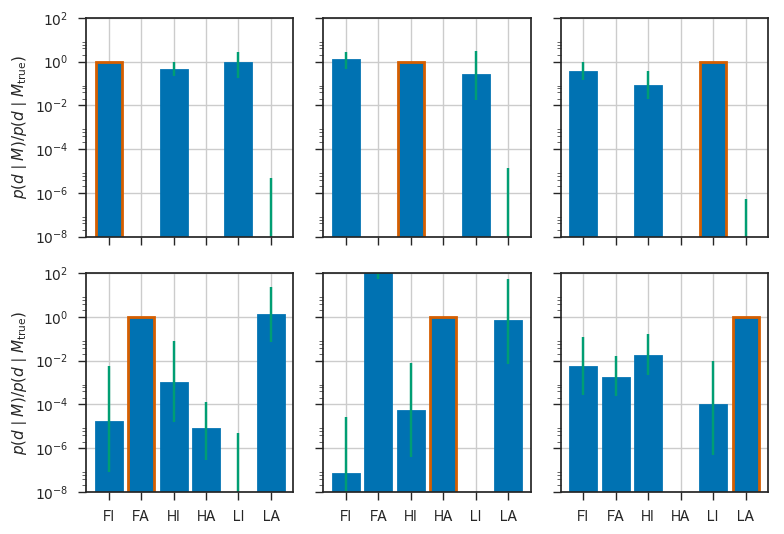

In case LA, median iso-aligned odds ratio   0.015 (    2.4 sigma)
            5% iso-aligned odds ratio        0.48 (    0.7 sigma)


In [29]:
function mockcatalog(n, draw_chieff)
    samples = []
    for i in 1:n
        sigma = rand([sigmaGW150914, sigmaLVT151012, sigmaGW151226])
        chieff_true = draw_chieff()
        
        chieff_obs = chieff_true + sigma*randn()
        chieff_samps = chieff_obs + sigma*randn(10000)
        chieff_wts = p_iso_flat.(chieff_samps)
        
        cesamps = []
        wtmax = maximum(chieff_wts)
        for (ce, w) in zip(chieff_samps, chieff_wts)
            r = wtmax*rand()
            if r < w
                push!(cesamps, ce)
            end
        end
        
        push!(samples, cesamps)
    end
    samples
end

model_names = ["FI", "FA", "HI", "HA", "LI", "LA"]
draw_functions = [
    () -> draw_chieff(1.0, () -> rand()*draw_iota()),
    () -> draw_chieff(1.0, rand),
    () -> draw_chieff(1.0, () -> draw_increasing()*draw_iota()),
    () -> draw_chieff(1.0, () -> draw_increasing()),
    () -> draw_chieff(1.0, () -> draw_decreasing()*draw_iota()),
    () -> draw_chieff(1.0, () -> draw_decreasing())
]
distribution_functions = [
    p_iso_flat,
    p_ali_flat,
    p_iso_inc,
    p_ali_inc,
    p_iso_dec,
    p_ali_dec
]

function model_loglikes(samples, p_prior)
    [marginal_model_likelihood(samples, df, p_prior) for df in distribution_functions] 
end
fig, axs = subplots(2,3,sharex=true,sharey=true)
subplots_adjust(hspace=0, wspace=0.1)
nmc = 1000

data_rows = []
header = vcat(["truth"], vcat([["$(n)_med", "$(n)_uncert_plus", "$(n)_uncert_minus"] for n in model_names]...))

for i in eachindex(draw_functions)
    ax = axs[i]
    lls = []
    for j in 1:nmc
        mockO2 = vcat(mocksamples, mockcatalog(10, draw_functions[i]))
        ll = model_loglikes(mockO2, p_iso_flat)
        ll = ll .- ll[i]
        push!(lls, ll)
    end
    lls = hcat(lls...)
    med_ls = [quantile(vec(lls[i,:]), 0.5) for i in 1:6]
    low_ls = [quantile(vec(lls[i,:]), 0.16) for i in 1:6]
    high_ls = [quantile(vec(lls[i,:]), 0.84) for i in 1:6]

    log_er_iso_ali = Float64[]
    for j in 1:nmc
        push!(log_er_iso_ali, max(lls[1,j], lls[3,j], lls[5,j]) - max(lls[2,j], lls[4,j], lls[6,j]))
    end
    
    med_er = exp(-median(abs(log_er_iso_ali))) # abs(...) because we want to measure the 50% most-extreme in either direction
    med_sigma = inv_gaussian_cdf(med_er/2.0)
    p5_least_extreme_er = exp(-quantile(abs(log_er_iso_ali), 0.05))
    p5_least_extreme_sigma = inv_gaussian_cdf(p5_least_extreme_er/2.0)
    println(@sprintf("In case %s, median iso-aligned odds ratio %7.02g (%7.02g sigma)", model_names[i], med_er, med_sigma))
    println(@sprintf("            5%% iso-aligned odds ratio     %7.02g (%7.02g sigma)", p5_least_extreme_er, p5_least_extreme_sigma))

    y = exp(med_ls)
    yerr_high = exp(high_ls) - exp(med_ls)
    yerr_low = exp(med_ls) - exp(low_ls)
    yerr = vcat(yerr_low', yerr_high')
    ecolor = [sns.color_palette()[1] for j in 1:6]
    ecolor[i] = sns.color_palette()[3]
    ax[:bar](collect(1:6), y, align="center", yerr=yerr, ecolor=sns.color_palette()[2], tick_label=model_names, edgecolor=ecolor, color=sns.color_palette()[1], linewidth=2)
    ax[:set_yscale]("log")
    ax[:set_ylim]((1e-8,100))
    ax[:grid]()
    if (i==1) || (i==2)
        ax[:set_ylabel](L"$p\left( d \mid M \right) / p\left( d \mid M_\mathrm{true} \right)$")
    end
    
    push!(data_rows, vcat([model_names[i]], vcat([[y[j], yerr_high[j], yerr_low[j]] for j in eachindex(y)]...)))
end
tight_layout()
savefig("../plots/six-way-O2-model-selection.pdf")

open("../data/future-model-selection.csv", "w") do f
    write(f, join(header, ","))
    write(f, "\n")
    writecsv(f, data_rows)
end

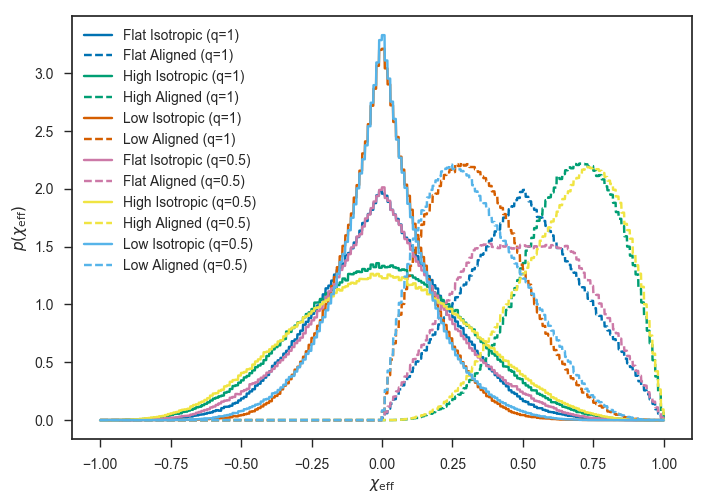

In [22]:
bins = collect(-1:0.01:1) # Hopefully spaced finely enough

p_ali_flat_05 = make_histogram_density(bins, hist_counts(bins, [draw_chieff(0.5, rand) for i in 1:1000000])[2])
p_iso_flat_05 = make_histogram_density(bins, hist_counts(bins, [draw_chieff(0.5, () -> draw_iota()*rand()) for i in 1:1000000])[2])

p_ali_inc_05 = make_histogram_density(bins, hist_counts(bins, [draw_chieff(0.5, draw_increasing) for i in 1:1000000])[2])
p_iso_inc_05 = make_histogram_density(bins, hist_counts(bins, [draw_chieff(0.5, () -> draw_iota()*draw_increasing()) for i in 1:1000000])[2])

p_ali_dec_05 = make_histogram_density(bins, hist_counts(bins, [draw_chieff(0.5, draw_decreasing) for i in 1:1000000])[2])
p_iso_dec_05 = make_histogram_density(bins, hist_counts(bins, [draw_chieff(0.5, () -> draw_iota()*draw_decreasing()) for i in 1:1000000])[2])

chieffs = collect(-1:0.001:1)

plot(chieffs, p_iso_flat.(chieffs), "-", color=sns.color_palette()[1], label="Flat Isotropic (q=1)")
plot(chieffs, p_ali_flat.(chieffs), "--", color=sns.color_palette()[1], label="Flat Aligned (q=1)")

plot(chieffs, p_iso_inc.(chieffs), "-", color=sns.color_palette()[2], label="High Isotropic (q=1)")
plot(chieffs, p_ali_inc.(chieffs), "--", color=sns.color_palette()[2], label="High Aligned (q=1)")

plot(chieffs, p_iso_dec.(chieffs), "-", color=sns.color_palette()[3], label="Low Isotropic (q=1)")
plot(chieffs, p_ali_dec.(chieffs), "--", color=sns.color_palette()[3], label="Low Aligned (q=1)")

plot(chieffs, p_iso_flat_05.(chieffs), "-", color=sns.color_palette()[4], label="Flat Isotropic (q=0.5)")
plot(chieffs, p_ali_flat_05.(chieffs), "--", color=sns.color_palette()[4], label="Flat Aligned (q=0.5)")

plot(chieffs, p_iso_inc_05.(chieffs), "-", color=sns.color_palette()[5], label="High Isotropic (q=0.5)")
plot(chieffs, p_ali_inc_05.(chieffs), "--", color=sns.color_palette()[5], label="High Aligned (q=0.5)")

plot(chieffs, p_iso_dec_05.(chieffs), "-", color=sns.color_palette()[6], label="Low Isotropic (q=0.5)")
plot(chieffs, p_ali_dec_05.(chieffs), "--", color=sns.color_palette()[6], label="Low Aligned (q=0.5)")

legend(loc="best")
xlabel(L"$\chi_\mathrm{eff}$")
ylabel(L"$p\left( \chi_\mathrm{eff}\right)$")
savefig("../plots/chi-eff-distributions-q05.pdf")